In [2]:
!pip install rdkit
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.3.0+cpu.html --quiet
!pip install networkx --quiet
!pip install pyarrow --quiet
!pip install matplotlib-venn --quiet
!pip install optuna --quiet

!pip install rdkit-pypi --quiet
!pip install networkx pyarrow optuna matplotlib-venn --quiet

!pip uninstall -y torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric
!pip install torch-geometric -f https://data.pyg.org/whl/torch-2.4.0+cu124.html --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.6/513.6 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 783.8/783.8 kB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.2/217.2 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 11.3 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement rdkit-pypi (from versions: none)
ERROR: No matching distribution found for rdkit-pypi
Found existing installation: torch_scatter 2.1.2+pt23cpu
Uninstalling torch_scatter-2.1.2+pt23cpu:
  Successfully uninstalled torch_scatter-2.1.2+pt23cpu
Found existing installation: torch_sparse 0.6.18+pt23cpu
Uninstalling torch_sparse-0.6.18+pt23cpu:
  Successfully uninstalled torch_spars

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
import math
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader

from rdkit import Chem
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch_geometric.data import Data as PyGData, Batch
from torch_geometric.nn import GINEConv, global_mean_pool
import matplotlib.pyplot as plt

In [6]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

In [7]:
# Load and preprocess data
drugcomb = pd.read_pickle("/content/drive/MyDrive/drugcomb_eda.pkl")
cancer_onehots = [c for c in drugcomb.columns if c.startswith("cancer_type_") and c != "cancer_type"]
if len(cancer_onehots) == 0:
    drugcomb = pd.concat([drugcomb, pd.get_dummies(drugcomb["cancer_type"], prefix="cancer_type")], axis=1)
    cancer_onehots = [c for c in drugcomb.columns if c.startswith("cancer_type_") and c != "cancer_type"]


In [8]:
cell_le = LabelEncoder()
drugcomb["cell_line_enc"] = cell_le.fit_transform(drugcomb["cell_line_name"].astype(str))
num_cells = len(cell_le.classes_)

In [9]:
# Scale target variable
scaler_y = StandardScaler()
drugcomb["synergy_zip_scaled"] = scaler_y.fit_transform(drugcomb[["synergy_zip"]])

In [10]:
# Symmetry augmentation
aug = drugcomb.copy()
aug = aug.rename(columns={"drug_row_smiles":"drug_col_smiles", "drug_col_smiles":"drug_row_smiles"})
drugcomb_aug = pd.concat([drugcomb, aug], ignore_index=True).reset_index(drop=True)
drugcomb = drugcomb_aug
print(f"Dataset size after symmetry augmentation: {len(drugcomb)}")

Dataset size after symmetry augmentation: 1123508


In [11]:
def mol_to_pyg(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    atom_feats = []
    for atom in mol.GetAtoms():
        atom_feats.append([
            atom.GetAtomicNum(),
            atom.GetTotalNumHs(),
            atom.GetDegree(),
            atom.GetImplicitValence(),
            1.0 if atom.GetIsAromatic() else 0.0
        ])
    x = torch.tensor(atom_feats, dtype=torch.float)
    edge_index = []
    edge_attr = []
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtomIdx()
        a2 = bond.GetEndAtomIdx()
        bt = bond.GetBondType()
        bt_val = {
            Chem.rdchem.BondType.SINGLE: 1.0,
            Chem.rdchem.BondType.DOUBLE: 2.0,
            Chem.rdchem.BondType.TRIPLE: 3.0,
            Chem.rdchem.BondType.AROMATIC: 1.5
        }.get(bt, 0.0)
        edge_index.append([a1, a2])
        edge_attr.append([bt_val])
        edge_index.append([a2, a1])
        edge_attr.append([bt_val])

    if len(edge_index) == 0:
        edge_index = [[0,0]]
        edge_attr = [[0.0]]

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    data = PyGData(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data

In [12]:
smiles_set = set(pd.concat([drugcomb["drug_row_smiles"], drugcomb["drug_col_smiles"]]).unique())
smiles_to_graph = {}
print("Building molecular graphs for unique SMILES...")
for s in tqdm(smiles_set):
    g = mol_to_pyg(s)
    if g is None:
        raise ValueError(f"Could not parse SMILES: {s}")
    smiles_to_graph[s] = g

Building molecular graphs for unique SMILES...


Streaming output truncated to the last 5000 lines.
[18:35:09] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:35:09] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:35:09] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:35:09] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:35:09] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:35:09] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:35:09] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:35:09] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:35:09] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:35:09] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:35:09] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:35:09] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:35:09] DEPRECATION WARNING: please use GetValence(getExplicit=False)


In [13]:
class DrugPairGraphDataset(Dataset):
    def __init__(self, df, cancer_cols, smiles_map):
        self.df = df.reset_index(drop=True)
        self.cancer_cols = cancer_cols
        self.smiles_map = smiles_map

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        g1 = self.smiles_map[row["drug_row_smiles"]]
        g2 = self.smiles_map[row["drug_col_smiles"]]
        cancer_vec = torch.tensor(row[self.cancer_cols].values.astype(np.float32), dtype=torch.float)
        cell_idx = int(row["cell_line_enc"])
        y = float(row["synergy_zip_scaled"])
        return g1, g2, cancer_vec, torch.tensor(cell_idx, dtype=torch.long), torch.tensor(y, dtype=torch.float)

In [14]:
def collate_pairs(batch):
    g1_list, g2_list, cancer_list, cell_list, y_list = [], [], [], [], []
    for g1, g2, cancer_vec, cell_idx, y in batch:
        g1_list.append(g1)
        g2_list.append(g2)
        cancer_list.append(cancer_vec)
        cell_list.append(cell_idx)
        y_list.append(y)
    batch_g1 = Batch.from_data_list(g1_list)
    batch_g2 = Batch.from_data_list(g2_list)
    cancer_tensor = torch.stack(cancer_list, dim=0)
    cell_tensor = torch.stack(cell_list, dim=0)
    y_tensor = torch.stack([v if isinstance(v, torch.Tensor) else torch.tensor(v) for v in y_list], dim=0)
    return batch_g1, batch_g2, cancer_tensor, cell_tensor, y_tensor

In [15]:
dataset = DrugPairGraphDataset(drugcomb, cancer_onehots, smiles_to_graph)
n = len(dataset)
train_n = int(0.8 * n)
test_n = n - train_n
train_ds, test_ds = torch.utils.data.random_split(dataset, [train_n, test_n])
print(f"Train size: {len(train_ds)}, Test size: {len(test_ds)}")

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_pairs, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, collate_fn=collate_pairs, num_workers=0)

Train size: 898806, Test size: 224702


In [16]:
class GraphEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_layers, edge_dim):
        super().__init__()
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()

        for i in range(num_layers):
            input_dim = in_dim if i == 0 else hidden_dim
            conv = GINEConv(
                nn.Sequential(
                    nn.Linear(input_dim, hidden_dim),
                    nn.ReLU(),
                    nn.Linear(hidden_dim, hidden_dim)
                ),
                edge_dim=edge_dim
            )
            self.convs.append(conv)
            self.bns.append(nn.BatchNorm1d(hidden_dim))

    def forward(self, x, edge_index, edge_attr, batch):
        for conv, bn in zip(self.convs, self.bns):
            x = conv(x, edge_index, edge_attr)
            x = bn(x)
            x = F.relu(x)
        x = global_mean_pool(x, batch)
        return x

In [17]:
class DualGNNModel(nn.Module):
    def __init__(self, node_feat_dim, cancer_dim, num_cells, cell_emb_dim,
                 gnn_hidden, gnn_layers, mlp_hidden, dropout, edge_dim):
        super().__init__()

        self.encoder = GraphEncoder(node_feat_dim, gnn_hidden, gnn_layers, edge_dim)
        self.cell_emb = nn.Embedding(num_cells, cell_emb_dim)

        self.fc1 = nn.Linear(gnn_hidden * 2 + cancer_dim + cell_emb_dim, mlp_hidden)
        self.fc2 = nn.Linear(mlp_hidden, mlp_hidden // 2)
        self.fc3 = nn.Linear(mlp_hidden // 2, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, batch_g1, batch_g2, cancer_vec, cell_idx):
        x1, e1_idx, e1_attr = batch_g1.x, batch_g1.edge_index, batch_g1.edge_attr
        x2, e2_idx, e2_attr = batch_g2.x, batch_g2.edge_index, batch_g2.edge_attr

        emb1 = self.encoder(x1, e1_idx, e1_attr, batch_g1.batch)
        emb2 = self.encoder(x2, e2_idx, e2_attr, batch_g2.batch)
        cell_embed = self.cell_emb(cell_idx)

        combined = torch.cat([emb1, emb2, cancer_vec, cell_embed], dim=1)
        x = F.relu(self.fc1(combined))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        out = self.fc3(x)
        return out

In [18]:
# EVALUATION FUNCTION
def evaluate(model, loader, device, scaler_y, return_predictions=False):
    """Evaluate model with proper scaling - returns ORIGINAL scale metrics"""
    model.eval()
    y_true_scaled_list, y_pred_scaled_list = [], []

    with torch.no_grad():
        for batch_g1, batch_g2, cancer_vec, cell_idx, y in loader:
            batch_g1 = batch_g1.to(device)
            batch_g2 = batch_g2.to(device)
            cancer_vec = cancer_vec.to(device)
            cell_idx = cell_idx.to(device)
            y = y.to(device)

            preds = model(batch_g1, batch_g2, cancer_vec, cell_idx)
            preds = preds.squeeze(-1)
            y = y.view(-1)

            y_true_scaled_list.append(y.cpu())
            y_pred_scaled_list.append(preds.cpu())

    # Concatenate results
    y_true_scaled = torch.cat(y_true_scaled_list).numpy()
    y_pred_scaled = torch.cat(y_pred_scaled_list).numpy()

    # Convert to original scale for meaningful metrics
    y_true_orig = scaler_y.inverse_transform(y_true_scaled.reshape(-1, 1)).ravel()
    y_pred_orig = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

    # Calculate metrics on ORIGINAL scale (meaningful for interpretation)
    mae_orig = mean_absolute_error(y_true_orig, y_pred_orig)
    rmse_orig = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    r2_orig = r2_score(y_true_orig, y_pred_orig)

    # Also calculate scaled metrics for reference
    mae_scaled = mean_absolute_error(y_true_scaled, y_pred_scaled)
    rmse_scaled = np.sqrt(mean_squared_error(y_true_scaled, y_pred_scaled))
    r2_scaled = r2_score(y_true_scaled, y_pred_scaled)

    results = {
        'metrics_original': {
            'mae': mae_orig,
            'rmse': rmse_orig,
            'r2': r2_orig
        },
        'metrics_scaled': {
            'mae': mae_scaled,
            'rmse': rmse_scaled,
            'r2': r2_scaled
        },
        'y_true_orig': y_true_orig,
        'y_pred_orig': y_pred_orig,
        'data_range': np.max(y_true_orig) - np.min(y_true_orig)
    }

    if return_predictions:
        return results
    else:
        return {k: v for k, v in results.items() if k not in ['y_true_orig', 'y_pred_orig']}


In [19]:
# NEW: Function to calculate expected metrics based on data range
def calculate_expected_metrics(data_range, problem_difficulty="hard"):
    """
    Calculate expected 'good' metrics based on data range and problem difficulty
    """
    if problem_difficulty == "easy":
        mae_ratio = 0.05    # MAE should be < 5% of range
        rmse_ratio = 0.07   # RMSE should be < 7% of range
        min_r2 = 0.8
    elif problem_difficulty == "medium":
        mae_ratio = 0.10    # MAE should be < 10% of range
        rmse_ratio = 0.15   # RMSE should be < 15% of range
        min_r2 = 0.6
    else:  # hard (like drug synergy)
        mae_ratio = 0.15    # MAE should be < 15% of range
        rmse_ratio = 0.20   # RMSE should be < 20% of range
        min_r2 = 0.4

    expected_mae = data_range * mae_ratio
    expected_rmse = data_range * rmse_ratio

    return {
        'expected_mae': expected_mae,
        'expected_rmse': expected_rmse,
        'expected_r2': min_r2,
        'mae_percent_of_range': mae_ratio * 100,
        'rmse_percent_of_range': rmse_ratio * 100
    }

In [20]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print("Using device:", device)

edge_dim = list(smiles_to_graph.values())[0].edge_attr.shape[1]
node_feat_dim = list(smiles_to_graph.values())[0].x.shape[1]

model = DualGNNModel(
    node_feat_dim=node_feat_dim,
    cancer_dim=len(cancer_onehots),
    num_cells=num_cells,
    cell_emb_dim=48,
    gnn_hidden=192,
    gnn_layers=4,
    mlp_hidden=512,
    dropout=0.3,
    edge_dim=edge_dim
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)
criterion = torch.nn.MSELoss()
scaler_gpu = torch.amp.GradScaler('cuda')

num_epochs = 20
best_val_loss = float("inf")
patience = 6
patience_counter = 0
use_amp = True

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0.0

    for batch_g1, batch_g2, cancer_vec, cell_idx, y in tqdm(train_loader, desc=f"Train Epoch {epoch}/{num_epochs}"):
        batch_g1 = batch_g1.to(device, non_blocking=True)
        batch_g2 = batch_g2.to(device, non_blocking=True)
        cancer_vec = cancer_vec.to(device, non_blocking=True)
        cell_idx = cell_idx.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad()

        if use_amp:
            # FIXED: Use new AMP API
            with torch.amp.autocast('cuda'):
                preds = model(batch_g1, batch_g2, cancer_vec, cell_idx)
                preds = preds.squeeze(-1)
                y = y.view(-1)
                loss = criterion(preds, y)
        else:
            preds = model(batch_g1, batch_g2, cancer_vec, cell_idx)
            preds = preds.squeeze(-1)
            y = y.view(-1)
            loss = criterion(preds, y)

        scaler_gpu.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler_gpu.step(optimizer)
        scaler_gpu.update()

        total_loss += loss.item() * y.size(0)

    train_loss = total_loss / len(train_ds)
    scheduler.step()

    val_res = evaluate(model, test_loader, device, scaler_y)
    val_loss = val_res['metrics_scaled']['rmse']  # Use scaled RMSE for early stopping

    print(f"Epoch {epoch} | train_loss: {train_loss:.4f} | val_loss: {val_loss:.4f} | "
          f"RMSE (orig): {val_res['metrics_original']['rmse']:.4f} | R2 (orig): {val_res['metrics_original']['r2']:.4f}")

    if val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "gnn_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping.")
            break

Using device: cuda


Train Epoch 1/20: 100%|██████████| 7022/7022 [11:21<00:00, 10.30it/s]


Epoch 1 | train_loss: 0.8330 | val_loss: 0.8919 | RMSE (orig): 7.6127 | R2 (orig): 0.2070


Train Epoch 2/20: 100%|██████████| 7022/7022 [10:45<00:00, 10.89it/s]


Epoch 2 | train_loss: 0.7523 | val_loss: 0.8513 | RMSE (orig): 7.2660 | R2 (orig): 0.2776


Train Epoch 3/20: 100%|██████████| 7022/7022 [10:49<00:00, 10.81it/s]


Epoch 3 | train_loss: 0.6825 | val_loss: 0.8169 | RMSE (orig): 6.9728 | R2 (orig): 0.3347


Train Epoch 4/20: 100%|██████████| 7022/7022 [11:02<00:00, 10.60it/s]


Epoch 4 | train_loss: 0.6014 | val_loss: 0.7481 | RMSE (orig): 6.3855 | R2 (orig): 0.4421


Train Epoch 5/20: 100%|██████████| 7022/7022 [10:56<00:00, 10.70it/s]


Epoch 5 | train_loss: 0.5490 | val_loss: 0.7083 | RMSE (orig): 6.0455 | R2 (orig): 0.4999


Train Epoch 6/20: 100%|██████████| 7022/7022 [10:47<00:00, 10.84it/s]


Epoch 6 | train_loss: 0.5084 | val_loss: 0.6885 | RMSE (orig): 5.8764 | R2 (orig): 0.5275


Train Epoch 7/20: 100%|██████████| 7022/7022 [10:36<00:00, 11.04it/s]


Epoch 7 | train_loss: 0.4797 | val_loss: 0.6741 | RMSE (orig): 5.7534 | R2 (orig): 0.5471


Train Epoch 8/20: 100%|██████████| 7022/7022 [10:40<00:00, 10.97it/s]


Epoch 8 | train_loss: 0.4579 | val_loss: 0.6608 | RMSE (orig): 5.6400 | R2 (orig): 0.5647


Train Epoch 9/20: 100%|██████████| 7022/7022 [10:39<00:00, 10.98it/s]


Epoch 9 | train_loss: 0.4443 | val_loss: 0.6531 | RMSE (orig): 5.5747 | R2 (orig): 0.5748


Train Epoch 10/20: 100%|██████████| 7022/7022 [10:33<00:00, 11.09it/s]


Epoch 10 | train_loss: 0.4363 | val_loss: 0.6507 | RMSE (orig): 5.5538 | R2 (orig): 0.5779


Train Epoch 11/20: 100%|██████████| 7022/7022 [10:33<00:00, 11.09it/s]


Epoch 11 | train_loss: 0.5042 | val_loss: 0.6844 | RMSE (orig): 5.8415 | R2 (orig): 0.5331


Train Epoch 12/20: 100%|██████████| 7022/7022 [10:34<00:00, 11.06it/s]


Epoch 12 | train_loss: 0.4876 | val_loss: 0.6827 | RMSE (orig): 5.8275 | R2 (orig): 0.5353


Train Epoch 13/20: 100%|██████████| 7022/7022 [10:34<00:00, 11.07it/s]


Epoch 13 | train_loss: 0.4681 | val_loss: 0.6552 | RMSE (orig): 5.5921 | R2 (orig): 0.5721


Train Epoch 14/20: 100%|██████████| 7022/7022 [10:33<00:00, 11.08it/s]


Epoch 14 | train_loss: 0.4544 | val_loss: 0.6718 | RMSE (orig): 5.7342 | R2 (orig): 0.5501


Train Epoch 15/20: 100%|██████████| 7022/7022 [10:34<00:00, 11.07it/s]


Epoch 15 | train_loss: 0.4384 | val_loss: 0.6430 | RMSE (orig): 5.4880 | R2 (orig): 0.5879


Train Epoch 16/20: 100%|██████████| 7022/7022 [10:33<00:00, 11.09it/s]


Epoch 16 | train_loss: 0.4207 | val_loss: 0.6405 | RMSE (orig): 5.4669 | R2 (orig): 0.5910


Train Epoch 17/20: 100%|██████████| 7022/7022 [10:30<00:00, 11.14it/s]


Epoch 17 | train_loss: 0.4084 | val_loss: 0.6325 | RMSE (orig): 5.3988 | R2 (orig): 0.6012


Train Epoch 18/20: 100%|██████████| 7022/7022 [10:33<00:00, 11.08it/s]


Epoch 18 | train_loss: 0.3974 | val_loss: 0.6272 | RMSE (orig): 5.3534 | R2 (orig): 0.6079


Train Epoch 19/20: 100%|██████████| 7022/7022 [10:40<00:00, 10.96it/s]


Epoch 19 | train_loss: 0.3896 | val_loss: 0.6239 | RMSE (orig): 5.3256 | R2 (orig): 0.6119


Train Epoch 20/20: 100%|██████████| 7022/7022 [10:34<00:00, 11.07it/s]


Epoch 20 | train_loss: 0.3849 | val_loss: 0.6225 | RMSE (orig): 5.3137 | R2 (orig): 0.6137


In [21]:
# Load best model and do final evaluation
model.load_state_dict(torch.load("gnn_model.pt"))

# Final evaluation with CORRECT metrics
final_results = evaluate(model, test_loader, device, scaler_y, return_predictions=True)

print("\n" + "="*60)
print("FINAL EVALUATION RESULTS")
print("="*60)

print("\n PERFORMANCE ON ORIGINAL SCALE (Meaningful Metrics):")
for metric, value in final_results['metrics_original'].items():
    print(f"  {metric.upper()}: {value:.4f}")




FINAL EVALUATION RESULTS

 PERFORMANCE ON ORIGINAL SCALE (Meaningful Metrics):
  MAE: 3.8424
  RMSE: 5.3137
  R2: 0.6137

DATA CHARACTERISTICS:
  Data Range: 36.05 synergy points
  Your MAE: 3.84 (10.7% of range)
  Expected 'Good' MAE for hard problems: < 5.41 (15.0% of range)

  Your RMSE: 5.31 (14.7% of range)
  Expected 'Good' RMSE for hard problems: < 7.21 (20.0% of range)

  Your R²: 0.6137
  Expected 'Good' R² for hard problems: > 0.40


In [26]:
# Calculate expected metrics based on data range
data_range = final_results['data_range']
expected = calculate_expected_metrics(data_range, "hard")

print(f"\nDATA CHARACTERISTICS:")
print(f"  Data Range: {data_range:.2f} synergy points")
print(f"  Your MAE: {final_results['metrics_original']['mae']:.2f} ({final_results['metrics_original']['mae']/data_range*100:.1f}% of range)")
print(f"  Expected 'Good' MAE for hard problems: < {expected['expected_mae']:.2f} ({expected['mae_percent_of_range']:.1f}% of range)")

print(f"\n  Your RMSE: {final_results['metrics_original']['rmse']:.2f} ({final_results['metrics_original']['rmse']/data_range*100:.1f}% of range)")
print(f"  Expected 'Good' RMSE for hard problems: < {expected['expected_rmse']:.2f} ({expected['rmse_percent_of_range']:.1f}% of range)")

print(f"\n  Your R²: {final_results['metrics_original']['r2']:.4f}")
print(f"  Expected 'Good' R² for hard problems: > {expected['expected_r2']:.2f}")


DATA CHARACTERISTICS:
  Data Range: 36.05 synergy points
  Your MAE: 3.84 (10.7% of range)
  Expected 'Good' MAE for hard problems: < 5.41 (15.0% of range)

  Your RMSE: 5.31 (14.7% of range)
  Expected 'Good' RMSE for hard problems: < 7.21 (20.0% of range)

  Your R²: 0.6137
  Expected 'Good' R² for hard problems: > 0.40



 Model saved to final_gnn_model.pt


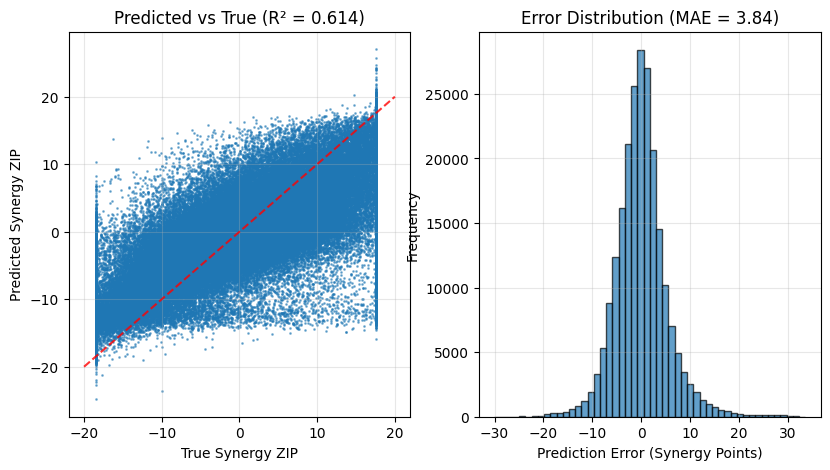

In [24]:
# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(final_results['y_true_orig'], final_results['y_pred_orig'], alpha=0.5, s=1)
plt.plot([-20, 20], [-20, 20], 'r--', alpha=0.8)
plt.xlabel('True Synergy ZIP')
plt.ylabel('Predicted Synergy ZIP')
plt.title(f'Predicted vs True (R² = {final_results["metrics_original"]["r2"]:.3f})')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
errors = final_results['y_true_orig'] - final_results['y_pred_orig']
plt.hist(errors, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Prediction Error (Synergy Points)')
plt.ylabel('Frequency')
plt.title(f'Error Distribution (MAE = {final_results["metrics_original"]["mae"]:.2f})')
plt.grid(True, alpha=0.3)



torch.save(model.state_dict(), "final_gnn_model.pt")
print("\n Model saved to final_gnn_model.pt")